# Pre-Panic vs. Non-Panic Prediction

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

In [4]:
from sklearn import cross_validation
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

plt.style.use('fivethirtyeight') # Good looking plots
pd.set_option('display.max_columns', None) # Display any number of columns

import seaborn as sns

In [5]:
# Constants
PANIC = 1
PREPANIC = 2

In [6]:
# Set random seed for consistent results
np.random.seed(9001)

In [7]:
df = pd.read_csv('all_subjects_dataset.csv')

In [8]:
df = df.dropna(axis=0)

In [9]:
df.head()

,Unnamed: 0,fileName,start_sec,end_sec,sdnn,sdann,sdnnidx,pnn50,sdsd,rmssd,irrr,madrr,tinn,hrv,hr,meanrr,VLF,ULF,LF,HF,LFnu,HFnu,LFHF,D2,sampleEn,maxLyapunov,dfa1,dfa2,sd1,sd2,rprec,rpratio,rpdet,rpdiv,rplmax,rplmean,rplmeanwithoutmain,rpentr,rptrend,rplam,rpvmax,rpvmean,label
0,1,2014_09_27-21_29_02_RR.csv,0,300,47.215173,17.932541,36.364650,5.960265,36.954148,36.914764,44,7.0,157.638889,10.088889,104.478338,578.418502,114.397596,188.554772,167.757948,39.847929,0.808060,0.191940,4.209954,4.694779,0.394127,0.019909,0.947884,0.729554,26.130288,61.319215,0.390249,2.315539,0.903638,0.006993,143,4.853398,4.816977,1.918492,-0.000844,0.950861,95,6.810051,0
1,2,2014_09_27-21_29_02_RR.csv,300,600,92.678480,52.813565,64.645212,1.452282,64.955506,64.889037,140,6.0,260.237069,16.655172,101.470537,594.989648,370.581285,792.646077,863.727793,433.971022,0.665584,0.334416,1.990289,6.685721,0.294915,0.016083,1.075474,1.035798,45.930479,122.780108,0.139390,6.568995,0.915653,0.003650,274,5.597286,5.489685,2.049691,-0.000877,0.956717,70,7.691292,0
2,3,2014_09_27-21_29_02_RR.csv,600,900,52.230016,37.153206,36.145785,1.151631,33.553703,33.522502,67,6.0,185.369318,11.863636,108.194023,556.442529,39.583279,385.002497,101.143889,38.697278,0.723277,0.276723,2.613721,5.126820,0.354790,0.019484,1.133262,0.933797,23.725909,69.886160,0.489153,1.910124,0.934343,0.002786,359,7.392914,7.356846,2.159484,-0.002346,0.965332,199,11.320636,0
3,4,2014_09_27-21_29_02_RR.csv,900,1200,51.754720,37.460051,26.234141,1.004016,14.901632,14.887665,69,6.0,181.322674,11.604651,104.909421,572.370742,21.862638,827.955147,52.006869,6.612746,0.887192,0.112808,7.864640,4.514220,0.371731,0.033080,1.610308,0.792742,10.537014,72.449576,0.489858,1.920959,0.940998,0.002558,391,12.124040,12.062933,2.216584,-0.001464,0.963045,273,18.485535,0
4,5,2014_09_27-21_29_02_RR.csv,1200,1500,43.663285,22.646376,35.844506,1.724138,26.320896,26.292535,53,7.5,168.968023,10.813953,99.687974,602.529032,84.682681,391.775437,261.140050,93.986974,0.735343,0.264657,2.778471,6.268005,0.386172,0.017408,1.153928,0.926247,18.611659,58.828233,0.584717,1.621961,0.948388,0.005376,186,5.650612,5.624464,2.045996,-0.000811,0.973440,187,8.557300,0


In [10]:
# Compare non-panic with either panic or pre-panic
df = df.ix[df['label'] != PANIC]

In [11]:
labels = np.asarray(df['label'].replace(0, 'Non-Panic').replace(1, 'Panic').replace(2, 'Pre-Panic')) 

In [12]:
labels

array(['Non-Panic', 'Non-Panic', 'Non-Panic', ..., 'Pre-Panic',
       'Pre-Panic', 'Pre-Panic'], dtype=object)

In [13]:
# Extract labels
y = np.asarray(df['label'])

In [14]:
# Convert RR from milliseconds to seconds (improves plot readability)
df['meanrr'] = df['meanrr'] / 1000.0

In [15]:
# Retain index for any error analysis
samples = np.asarray(df['Unnamed: 0'])

In [16]:
df.drop(['Unnamed: 0', 'fileName', 'start_sec', 'end_sec', 'label'], axis=1, inplace=True)

In [17]:
df.head()

,sdnn,sdann,sdnnidx,pnn50,sdsd,rmssd,irrr,madrr,tinn,hrv,hr,meanrr,VLF,ULF,LF,HF,LFnu,HFnu,LFHF,D2,sampleEn,maxLyapunov,dfa1,dfa2,sd1,sd2,rprec,rpratio,rpdet,rpdiv,rplmax,rplmean,rplmeanwithoutmain,rpentr,rptrend,rplam,rpvmax,rpvmean
0,47.215173,17.932541,36.364650,5.960265,36.954148,36.914764,44,7.0,157.638889,10.088889,104.478338,0.578419,114.397596,188.554772,167.757948,39.847929,0.808060,0.191940,4.209954,4.694779,0.394127,0.019909,0.947884,0.729554,26.130288,61.319215,0.390249,2.315539,0.903638,0.006993,143,4.853398,4.816977,1.918492,-0.000844,0.950861,95,6.810051
1,92.678480,52.813565,64.645212,1.452282,64.955506,64.889037,140,6.0,260.237069,16.655172,101.470537,0.594990,370.581285,792.646077,863.727793,433.971022,0.665584,0.334416,1.990289,6.685721,0.294915,0.016083,1.075474,1.035798,45.930479,122.780108,0.139390,6.568995,0.915653,0.003650,274,5.597286,5.489685,2.049691,-0.000877,0.956717,70,7.691292
2,52.230016,37.153206,36.145785,1.151631,33.553703,33.522502,67,6.0,185.369318,11.863636,108.194023,0.556443,39.583279,385.002497,101.143889,38.697278,0.723277,0.276723,2.613721,5.126820,0.354790,0.019484,1.133262,0.933797,23.725909,69.886160,0.489153,1.910124,0.934343,0.002786,359,7.392914,7.356846,2.159484,-0.002346,0.965332,199,11.320636
3,51.754720,37.460051,26.234141,1.004016,14.901632,14.887665,69,6.0,181.322674,11.604651,104.909421,0.572371,21.862638,827.955147,52.006869,6.612746,0.887192,0.112808,7.864640,4.514220,0.371731,0.033080,1.610308,0.792742,10.537014,72.449576,0.489858,1.920959,0.940998,0.002558,391,12.124040,12.062933,2.216584,-0.001464,0.963045,273,18.485535
4,43.663285,22.646376,35.844506,1.724138,26.320896,26.292535,53,7.5,168.968023,10.813953,99.687974,0.602529,84.682681,391.775437,261.140050,93.986974,0.735343,0.264657,2.778471,6.268005,0.386172,0.017408,1.153928,0.926247,18.611659,58.828233,0.584717,1.621961,0.948388,0.005376,186,5.650612,5.624464,2.045996,-0.000811,0.973440,187,8.557300


In [18]:
df.columns

Index([u'sdnn', u'sdann', u'sdnnidx', u'pnn50', u'sdsd', u'rmssd', u'irrr',
       u'madrr', u'tinn', u'hrv', u'hr', u'meanrr', u'VLF', u'ULF', u'LF',
       u'HF', u'LFnu', u'HFnu', u'LFHF', u'D2', u'sampleEn', u'maxLyapunov',
       u'dfa1', u'dfa2', u'sd1', u'sd2', u'rprec', u'rpratio', u'rpdet',
       u'rpdiv', u'rplmax', u'rplmean', u'rplmeanwithoutmain', u'rpentr',
       u'rptrend', u'rplam', u'rpvmax', u'rpvmean'],
      dtype='object')

In [19]:
X = np.asmatrix(df)

In [20]:
X.shape

(3057, 38)

# Feature Scaling

In [21]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Cross Validation

In [22]:
# Perform stratified cross-validation for specified classifier
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = cross_validation.StratifiedKFold(y, n_folds=n_folds, shuffle=shuffle)
    y_pred = np.zeros(y.shape)
    for ii, jj in stratified_k_fold:
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)        
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [27]:
y_pred_passive_aggressive = stratified_cv(X, y, linear_model.PassiveAggressiveClassifier)
y_pred_gradient_boosting = stratified_cv(X, y, ensemble.GradientBoostingClassifier)
y_pred_decision_tree = stratified_cv(X, y, tree.DecisionTreeClassifier)
y_pred_ridge = stratified_cv(X, y, linear_model.RidgeClassifier)
y_pred_svm = stratified_cv(X, y, svm.SVC)
y_pred_random_forest = stratified_cv(X, y, ensemble.RandomForestClassifier)
y_pred_k_neighbors = stratified_cv(X, y, neighbors.KNeighborsClassifier)
y_pred_logistic_regression = stratified_cv(X, y, linear_model.LogisticRegression)
y_pred_dumb = [np.argmax(np.bincount(y)) for ii in y.tolist()]

print('Passive Aggressive Classifier: {:.3f}'.format(metrics.accuracy_score(y, y_pred_passive_aggressive)))
print('Gradient Boosting Classifier:  {:.3f}'.format(metrics.accuracy_score(y, y_pred_gradient_boosting)))
print('Decision Tree Classifier:      {:.3f}'.format(metrics.accuracy_score(y, y_pred_decision_tree)))
print('RidgeClassifier:               {:.3f}'.format(metrics.accuracy_score(y, y_pred_ridge)))
print('Support vector machine(SVM):   {:.3f}'.format(metrics.accuracy_score(y, y_pred_svm)))
print('Random Forest Classifier:      {:.3f}'.format(metrics.accuracy_score(y, y_pred_random_forest)))
print('K Nearest Neighbor Classifier: {:.3f}'.format(metrics.accuracy_score(y, y_pred_k_neighbors)))
print('Logistic Regression:           {:.3f}'.format(metrics.accuracy_score(y, y_pred_logistic_regression)))
print('Dumb Classifier:               {:.3f}'.format(metrics.accuracy_score(y, y_pred_dumb)))

Passive Aggressive Classifier: 0.702
Gradient Boosting Classifier:  0.884
Decision Tree Classifier:      0.872
RidgeClassifier:               0.806
Support vector machine(SVM):   0.863
Random Forest Classifier:      0.905
K Nearest Neighbor Classifier: 0.875
Logistic Regression:           0.814
Dumb Classifier:               0.576


# Confusion Matrices

In [28]:
pass_agg_conf_matrix = metrics.confusion_matrix(y, y_pred_passive_aggressive)
grad_ens_conf_matrix = metrics.confusion_matrix(y, y_pred_gradient_boosting)
decision_conf_matrix = metrics.confusion_matrix(y, y_pred_decision_tree)
ridge_clf_conf_matrix = metrics.confusion_matrix(y, y_pred_ridge)
svm_svc_conf_matrix = metrics.confusion_matrix(y, y_pred_svm)
random_forest_conf_matrix = metrics.confusion_matrix(y, y_pred_random_forest)
k_neighbors_conf_matrix = metrics.confusion_matrix(y, y_pred_k_neighbors)
logistic_reg_conf_matrix = metrics.confusion_matrix(y, y_pred_logistic_regression)
dumb_conf_matrix = metrics.confusion_matrix(y, y_pred_dumb)

conf_matrix = {
                1: {
                    'matrix': pass_agg_conf_matrix,
                    'title': 'Passive Aggressive',
                   },
                2: {
                    'matrix': grad_ens_conf_matrix,
                    'title': 'Gradient Boosting',
                   },
                3: {
                    'matrix': decision_conf_matrix,
                    'title': 'Decision Tree',
                   },
                4: {
                    'matrix': ridge_clf_conf_matrix,
                    'title': 'Ridge',
                   },
                5: {
                    'matrix': svm_svc_conf_matrix,
                    'title': 'Support Vector Machine',
                   },
                6: {
                    'matrix': random_forest_conf_matrix,
                    'title': 'Random Forest',
                   },
                7: {
                    'matrix': k_neighbors_conf_matrix,
                    'title': 'K Nearest Neighbors',
                   },
                8: {
                    'matrix': logistic_reg_conf_matrix,
                    'title': 'Logistic Regression',
                   },
                9: {
                    'matrix': dumb_conf_matrix,
                    'title': 'Dumb',
                   },
}

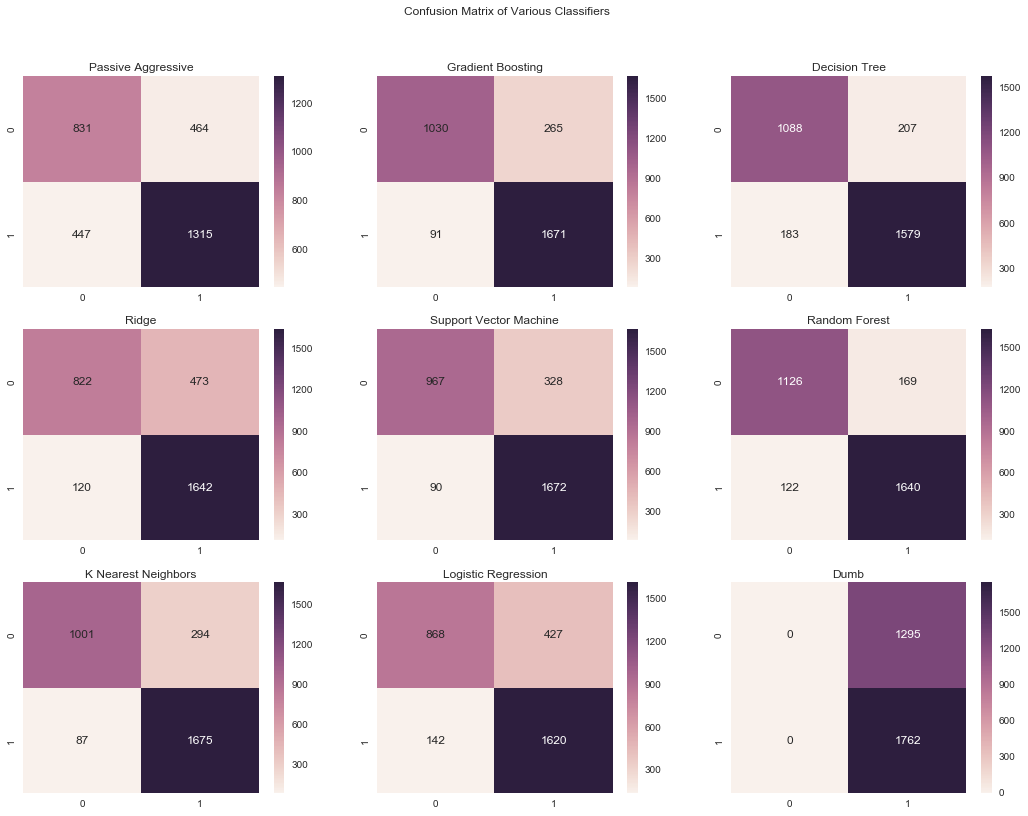

In [29]:
fix, ax = plt.subplots(figsize=(16, 12))
plt.suptitle('Confusion Matrix of Various Classifiers')
for ii, values in conf_matrix.items():
    matrix = values['matrix']
    title = values['title']
    plt.subplot(3, 3, ii) # starts from 1
    plt.title(title);
    sns.heatmap(matrix, annot=True,  fmt='');

# Feature Importance

In [30]:
def plot_feature_importance(feature_importances):
    # Use feature absolute value
    #feature_importances = abs(feature_importances)

    # Normalize The Features
    feature_importance = 100.0 * (feature_importances / abs(feature_importances).max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(16, 12))
    plt.barh(pos, feature_importance[sorted_idx], align='center', color='#7A68A6')
    plt.yticks(pos, np.asanyarray(df.columns.tolist())[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [31]:
def print_feature_importance(feature_importances):
    # Use feature absolute value
    #feature_importances = abs(feature_importances)

    # Normalize The Features
    feature_importance = 100.0 * (feature_importances / abs(feature_importances).max())
    sorted_idx = np.argsort(feature_importance)
    print np.asanyarray(df.columns.tolist())[sorted_idx]
    print feature_importance[sorted_idx]

In [70]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

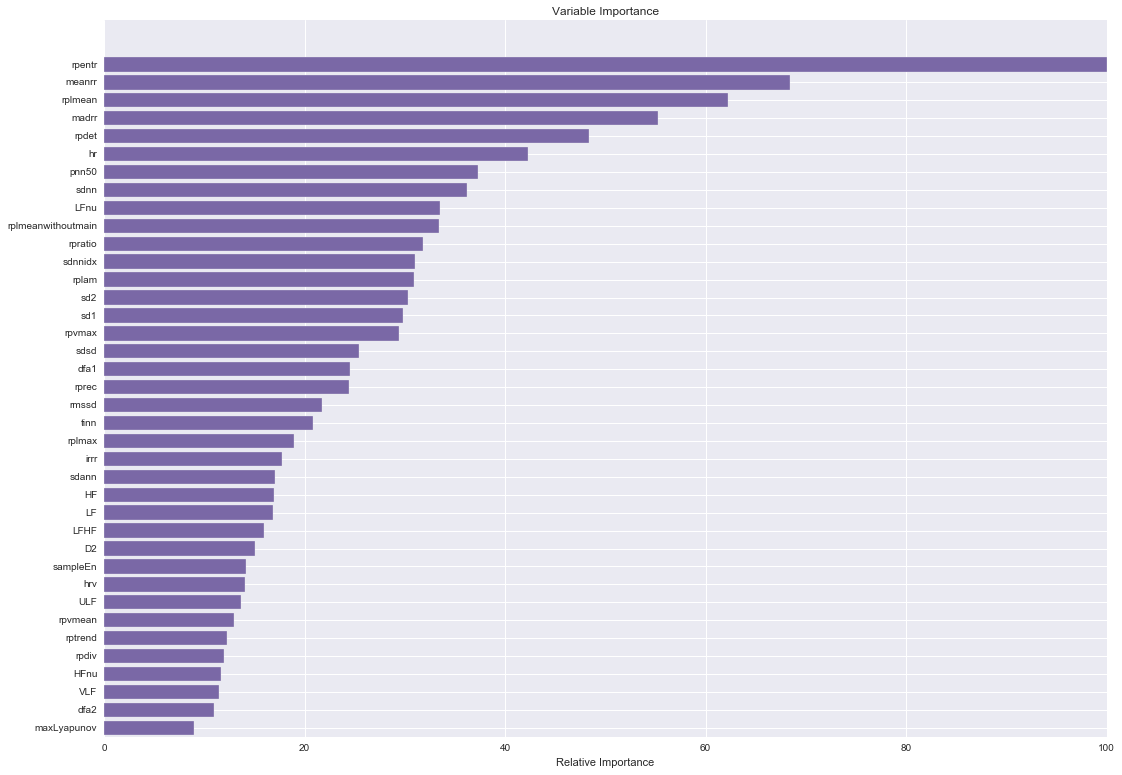

In [71]:
plot_feature_importance(rfc.feature_importances_)

In [72]:
df_top = df[['rpentr', 'meanrr', 'rplmean', 'madrr']]      # Top pre-panic

In [73]:
df_top['Label'] = labels 

/Users/jrubin/Developer/PervasiveHealth-2016/venv/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


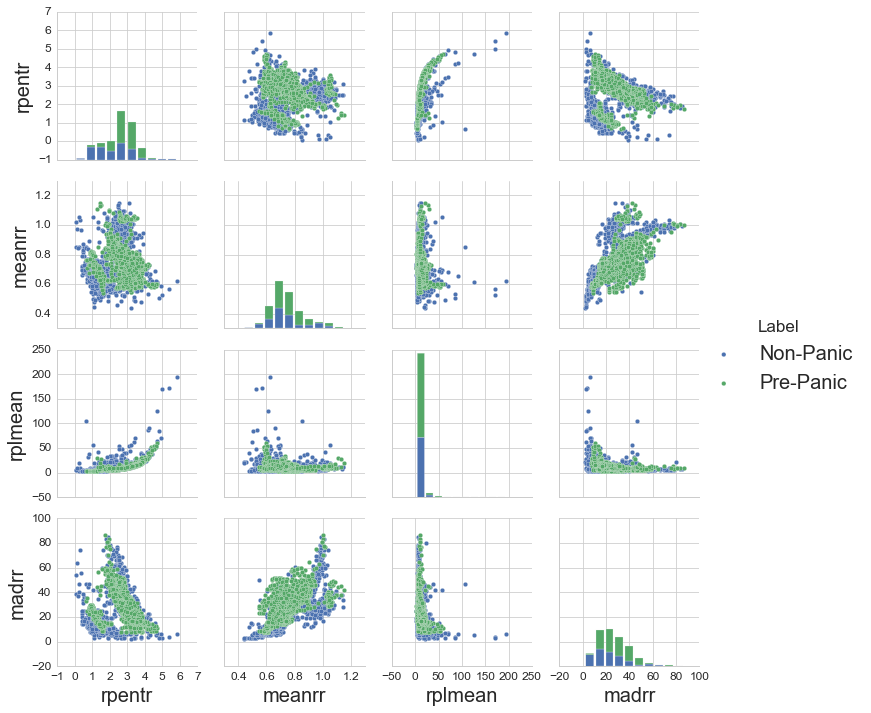

In [74]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale = 1.0, rc = {'axes.labelsize' : 20, 'legend.fontsize' : 20, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
sns.pairplot(df_top, hue='Label')

# Ablation Study - Linear, Frequency & Nonlinear

In [75]:
df_linear = df[['sdnn', 'sdann', 'sdnnidx', 'pnn50', 'sdsd', 'rmssd', 'irrr', 'madrr', 'tinn', 'hrv', 'hr', 'meanrr']]

In [76]:
df_freq = df[['VLF', 'ULF', 'LF', 'HF', 'LFnu', 'HFnu', 'LFHF']]

In [77]:
df_nonlinear = df[['D2', 'sampleEn', 'maxLyapunov', 'dfa1', 'dfa2', 'sd1', 'sd2', 'rprec', 'rpratio', 'rpdet',
                   'rpdiv', 'rplmax', 'rplmean', 'rplmeanwithoutmain', 'rpentr', 'rptrend', 'rplam', 'rpvmax', 'rpvmean']]

In [78]:
X_linear = np.asmatrix(df_linear)
X_freq = np.asmatrix(df_freq)
X_nonlinear = np.asmatrix(df_nonlinear)

In [79]:
scaler = preprocessing.StandardScaler()
X_linear = scaler.fit_transform(X_linear)
X_freq = scaler.fit_transform(X_freq)
X_nonlinear = scaler.fit_transform(X_nonlinear)

### Linear

In [80]:
print('Passive Aggressive Classifier: {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, ensemble.GradientBoostingClassifier))))
print('Decision Tree Classifier:      {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, tree.DecisionTreeClassifier))))
print('RidgeClassifier:               {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, linear_model.RidgeClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, svm.SVC))))
print('Random Forest Classifier:      {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_linear, y, linear_model.LogisticRegression))))

Passive Aggressive Classifier: 0.590
Gradient Boosting Classifier:  0.801
Decision Tree Classifier:      0.790
RidgeClassifier:               0.703
Support vector machine(SVM):   0.757
Random Forest Classifier:      0.834
K Nearest Neighbor Classifier: 0.812
Logistic Regression:           0.705


### Frequency Domain

In [81]:
print('Passive Aggressive Classifier: {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, ensemble.GradientBoostingClassifier))))
print('Decision Tree Classifier:      {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, tree.DecisionTreeClassifier))))
print('RidgeClassifier:               {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, linear_model.RidgeClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, svm.SVC))))
print('Random Forest Classifier:      {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_freq, y, linear_model.LogisticRegression))))

Passive Aggressive Classifier: 0.534
Gradient Boosting Classifier:  0.700
Decision Tree Classifier:      0.674
RidgeClassifier:               0.648
Support vector machine(SVM):   0.660
Random Forest Classifier:      0.684
K Nearest Neighbor Classifier: 0.682
Logistic Regression:           0.654


### Nonlinear

In [82]:
print('Passive Aggressive Classifier: {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, linear_model.PassiveAggressiveClassifier))))
print('Gradient Boosting Classifier:  {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, ensemble.GradientBoostingClassifier))))
print('Decision Tree Classifier:      {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, tree.DecisionTreeClassifier))))
print('RidgeClassifier:               {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, linear_model.RidgeClassifier))))
print('Support vector machine(SVM):   {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, svm.SVC))))
print('Random Forest Classifier:      {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.3f}'.format(metrics.accuracy_score(y, stratified_cv(X_nonlinear, y, linear_model.LogisticRegression))))

Passive Aggressive Classifier: 0.696
Gradient Boosting Classifier:  0.853
Decision Tree Classifier:      0.836
RidgeClassifier:               0.790
Support vector machine(SVM):   0.839
Random Forest Classifier:      0.880
K Nearest Neighbor Classifier: 0.854
Logistic Regression:           0.797
